In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [2]:
# Read the file
df = pd.read_csv('/Users/dianaterraza/Desktop/portfolio_project/notebooks/processed_data.csv')

# Display the first few rows of the dataframe
df.head()

,DATE,SGD_USD,CNY_USD
0,2000-01-03,1.6563,8.2798
1,2000-01-04,1.6535,8.2799
2,2000-01-05,1.6560,8.2798
3,2000-01-06,1.6655,8.2797
4,2000-01-07,1.6625,8.2794


## STEP 1: Data Preparation and Feature Engineering

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5217 entries, 0 to 5216
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     5217 non-null   object 
 1   SGD_USD  5217 non-null   float64
 2   CNY_USD  5217 non-null   float64
dtypes: float64(2), object(1)
memory usage: 122.4+ KB


In [4]:
# Feature engineering
for i in range(1, 13):  # 12 months of lag
    df[f'lag_{i}'] = df['SGD_USD'].shift(i)

df['rolling_mean_3'] = df['SGD_USD'].rolling(3).mean()
df['rolling_std_3'] = df['SGD_USD'].rolling(3).std()

df.dropna(inplace=True)

### Check for stationarity

In [5]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['SGD_USD'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])  # < 0.05 means stationary

ADF Statistic: -1.1708694609878874
p-value: 0.6859997624796221


##  STEP 2: Model Selection – ARIMA & SARIMA

### ARIMA MODELING

In [6]:
# Train/Test split
train = df.iloc[:-12]['SGD_USD']
test = df.iloc[-12:]['SGD_USD']

# Fit ARIMA
model_arima = ARIMA(train, order=(1,1,1))  # Tune this later
results_arima = model_arima.fit()
forecast_arima = results_arima.forecast(steps=12)

# Evaluation
print("ARIMA RMSE:", np.sqrt(mean_squared_error(test, forecast_arima)))


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA RMSE: 0.0037894409976848096


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### SARIMA MODELING

In [7]:
# Seasonal period = 12 for monthly data
model_sarima = SARIMAX(train, 
                       order=(1,1,1), 
                       seasonal_order=(1,1,1,12), 
                       enforce_stationarity=False,
                       enforce_invertibility=False)

results_sarima = model_sarima.fit()
forecast_sarima = results_sarima.forecast(steps=12)

print("SARIMA RMSE:", np.sqrt(mean_squared_error(test, forecast_sarima)))


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.79303D+00    |proj g|=  6.38573D+01

At iterate    5    f= -3.85611D+00    |proj g|=  2.89887D-01

At iterate   10    f= -3.85731D+00    |proj g|=  1.19446D+01

At iterate   15    f= -3.89303D+00    |proj g|=  4.66415D+01

At iterate   20    f= -3.91260D+00    |proj g|=  1.38034D-01

At iterate   25    f= -3.91432D+00    |proj g|=  1.97211D+01

At iterate   30    f= -3.91678D+00    |proj g|=  6.36323D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## STEP 3: Machine Learning Benchmark – XGBoost

In [14]:
# XGBoost
features = df.drop(columns=['SGD_USD'])
target = df['SGD_USD']

X_train, X_test = features.iloc[:-12], features.iloc[-12:]
y_train, y_test = target.iloc[:-12], target.iloc[-12:]

xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, pred_xgb))


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:DATE: datetime64[ns]

In [15]:
# XGBoost
features = df.drop(columns=['SGD_USD'])

# Handle the datetime column
if 'DATE' in features.columns:
    # Either drop it
    features = features.drop(columns=['DATE'])
    
    # Or extract features (uncomment to use)
    # features['day'] = features['DATE'].dt.day
    # features['month'] = features['DATE'].dt.month
    # features['year'] = features['DATE'].dt.year
    # features['day_of_week'] = features['DATE'].dt.dayofweek
    # features = features.drop(columns=['DATE'])

target = df['SGD_USD']

X_train, X_test = features.iloc[:-12], features.iloc[-12:]
y_train, y_test = target.iloc[:-12], target.iloc[-12:]

xgb = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)

print("XGBoost MAE:", mean_absolute_error(y_test, pred_xgb))

XGBoost MAE: 0.0010435014247894097


## STEP 4: Hyperparameter Optimization

In [16]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


### VISUAL COMPARISON

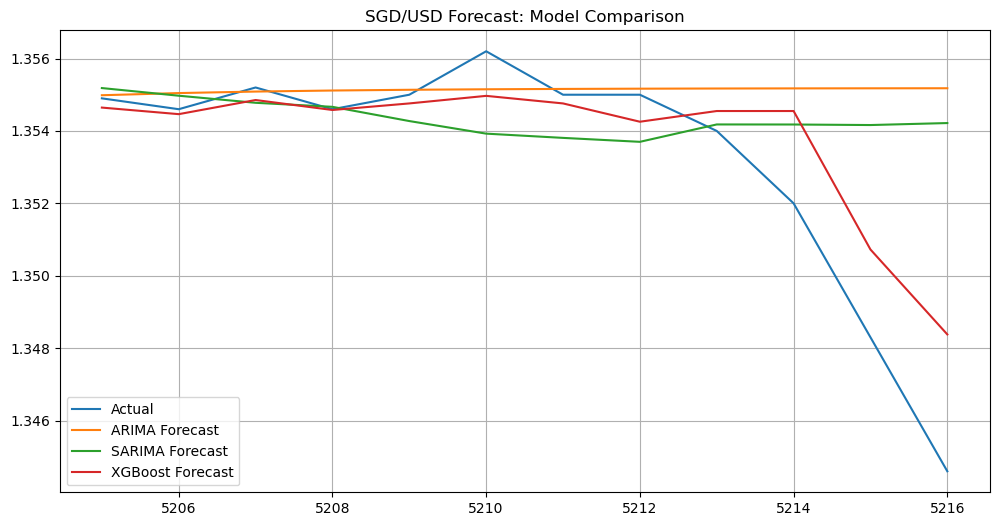

In [17]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast')
plt.plot(test.index, pred_xgb, label='XGBoost Forecast')
plt.title("SGD/USD Forecast: Model Comparison")
plt.legend()
plt.grid(True)
plt.show()
